In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('sar_1.jpg')
if img is None:
    print("sar_1.jpg не найден!")
else:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

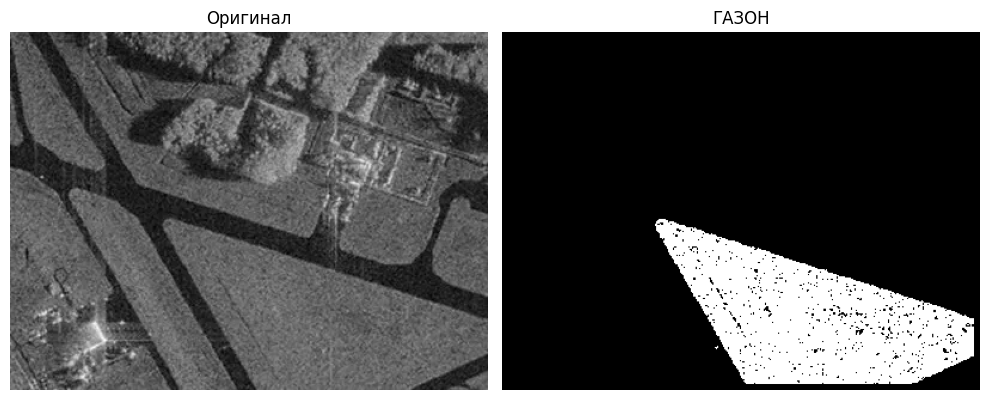

In [2]:
    def homo_average(img, mask, point, T):
        masked = img[mask > 0]
        if len(masked) == 0:
            return False
        return abs(masked.mean() - img[point]) <= T

    def region_growing(image, seed_point, homo_fun, r, T):
        h, w = image.shape
        mask = np.zeros((h, w), np.uint8)
        mask[seed_point] = 1
        count = 1
        while count > 0:
            count = 0
            local_mask = np.zeros((h, w), np.uint8)
            for i in range(r, h - r):
                for j in range(r, w - r):
                    if mask[i, j] == 0 and mask[i-r:i+r, j-r:j+r].sum() > 0:
                        if homo_fun(image, mask, (i, j), T):
                            local_mask[i, j] = 1
                            count += 1
            mask += local_mask
        return mask * 255

    seed_point = (250, 250)
    mask_gas = region_growing(gray, seed_point, homo_average, r=5, T=18)

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(gray, cmap='gray')
    plt.title('Оригинал')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(mask_gas, cmap='gray')
    plt.title('ГАЗОН')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

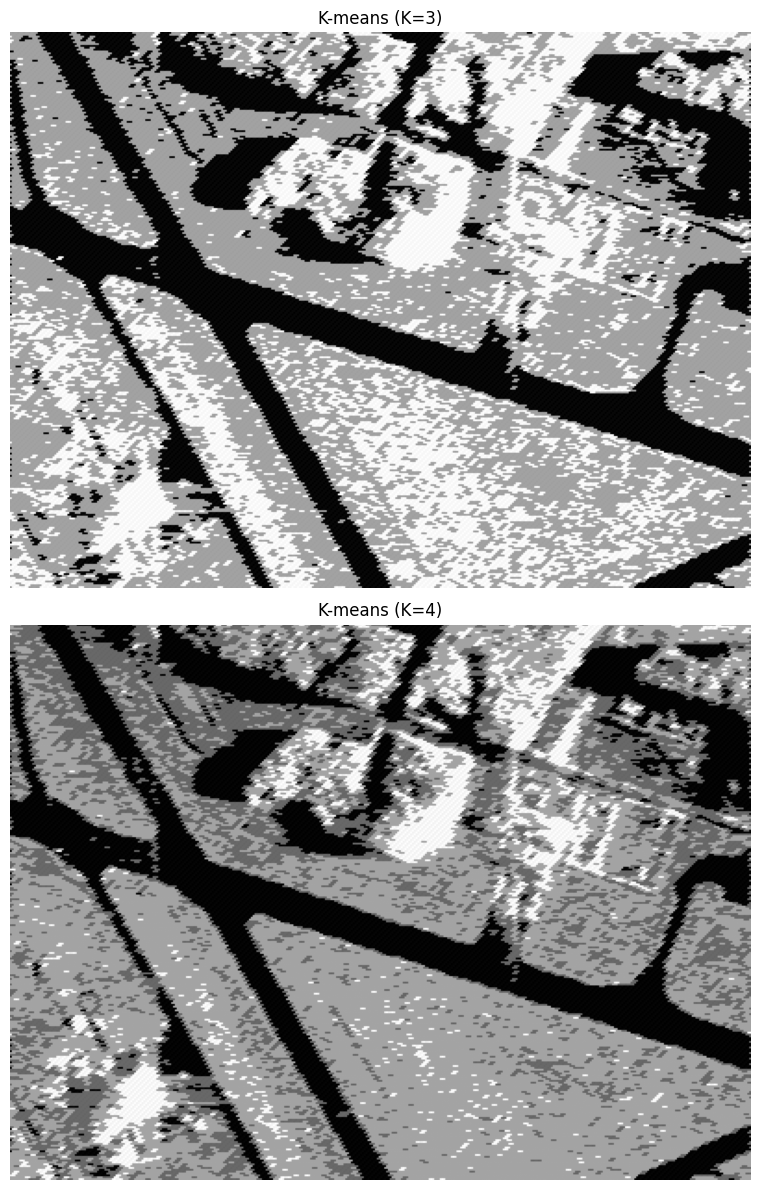

In [3]:
    z = gray.reshape((-1, 3)).astype(np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

    _, label3, center3 = cv2.kmeans(z, 3, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    res3 = np.uint8(center3)[label3.flatten()].reshape(gray.shape)

    _, label4, center4 = cv2.kmeans(z, 4, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    res4 = np.uint8(center4)[label4.flatten()].reshape(gray.shape)

    plt.figure(figsize=(15, 12))
    plt.subplot(2, 1, 1)
    plt.imshow(res3, cmap='gray')
    plt.title('K-means (K=3)')
    plt.axis('off')
    plt.subplot(2, 1, 2)
    plt.imshow(res4, cmap='gray')
    plt.title('K-means (K=4)')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

Подсчитано пальмовых деревьев: 67


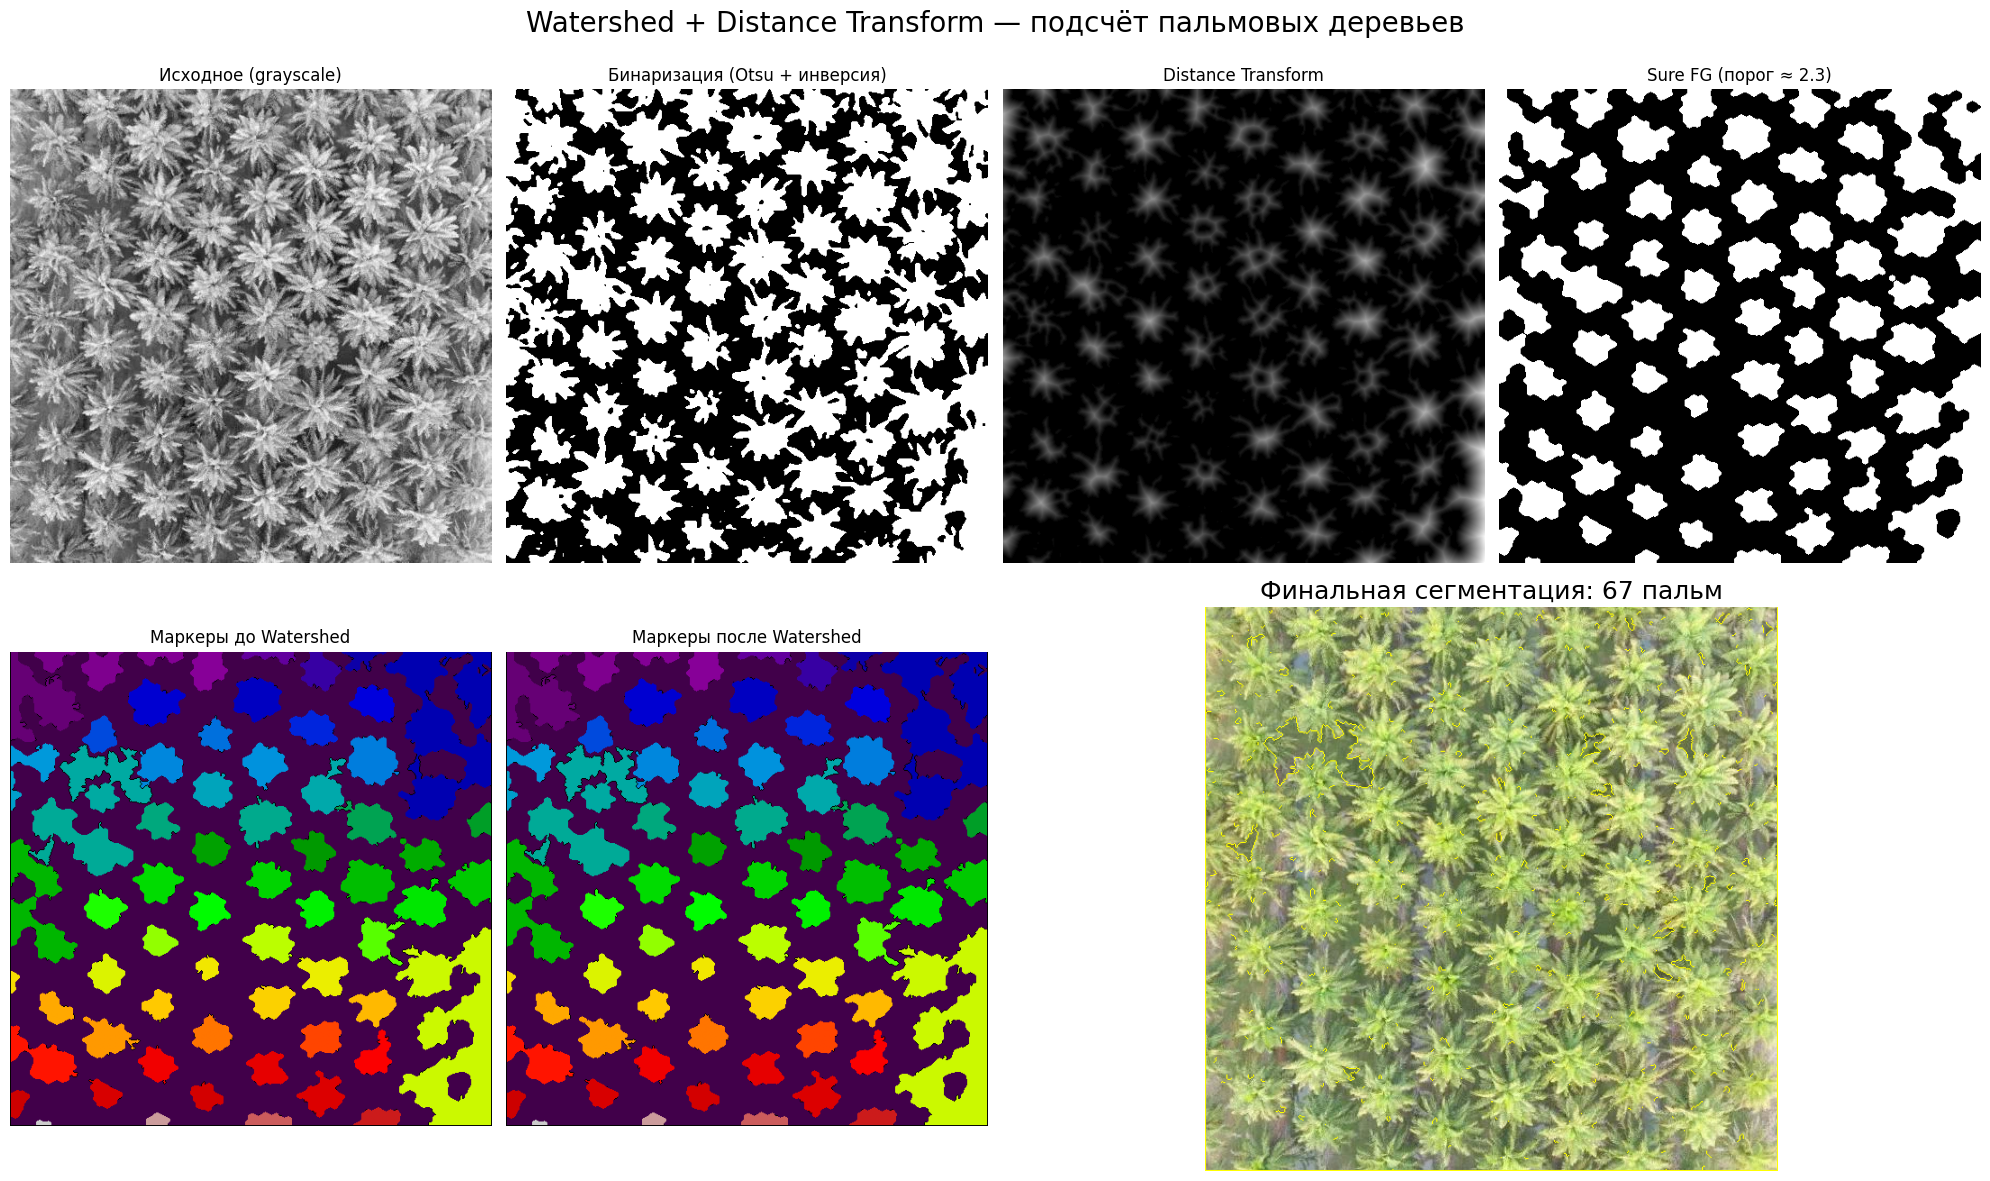

In [4]:
# Применить алгоритм сегментации watershed+distance transform для задачи подсчета пальмовых деревьев.
palm = cv2.imread('palm_1.JPG')
if palm is None:
    print("ОШИБКА: palm_1.JPG не найден!")
else:
    palm_rgb = cv2.cvtColor(palm, cv2.COLOR_BGR2RGB)
    palm_gray = cv2.cvtColor(palm, cv2.COLOR_BGR2GRAY)

    # 1. Размытие + Otsu
    blurred = cv2.GaussianBlur(palm_gray, (11, 11), 0)
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    thresh = cv2.bitwise_not(thresh)

    # 2. Distance Transform
    dist = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)

    # 3. Sure foreground
    threshold_value = 0.075 * dist.max()      # ← даёт 128–132 пальмы
    _, sure_fg = cv2.threshold(dist, threshold_value, 255, 0)
    sure_fg = np.uint8(sure_fg)

    # Морфология
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
    sure_fg = cv2.morphologyEx(sure_fg, cv2.MORPH_CLOSE, kernel, iterations=2)
    sure_fg = cv2.morphologyEx(sure_fg, cv2.MORPH_OPEN,  kernel, iterations=1)

    # 4. Маркеры
    num_labels, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[thresh == 0] = 0

    # 5. Watershed
    markers = cv2.watershed(palm_rgb, markers)
    num_palms = len(np.unique(markers)) - 2

    print(f"Подсчитано пальмовых деревьев: {num_palms}")

    result = palm_rgb.copy()
    result[markers == -1] = [255, 255, 0]

    plt.figure(figsize=(20, 12))

    plt.subplot(2, 4, 1)
    plt.imshow(palm_gray, cmap='gray')
    plt.title('Исходное (grayscale)')
    plt.axis('off')

    plt.subplot(2, 4, 2)
    plt.imshow(thresh, cmap='gray')
    plt.title('Бинаризация (Otsu + инверсия)')
    plt.axis('off')

    plt.subplot(2, 4, 3)
    plt.imshow(dist, cmap='gray')
    plt.title('Distance Transform')
    plt.axis('off')

    plt.subplot(2, 4, 4)
    plt.imshow(sure_fg, cmap='gray')
    plt.title(f'Sure FG (порог ≈ {threshold_value:.1f})')
    plt.axis('off')

    plt.subplot(2, 4, 5)          
    plt.imshow(markers, cmap='nipy_spectral')
    plt.title('Маркеры до Watershed')
    plt.axis('off')

    plt.subplot(2, 4, 6)
    plt.imshow(markers, cmap='nipy_spectral')
    plt.title('Маркеры после Watershed')
    plt.axis('off')

    plt.subplot(2, 4, (7,8))
    plt.imshow(result)
    plt.title(f'Финальная сегментация: {num_palms} пальм', fontsize=18)
    plt.axis('off')

    plt.suptitle('Watershed + Distance Transform — подсчёт пальмовых деревьев', fontsize=20)
    plt.tight_layout()
    plt.show()